In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple
import copy

In [2]:
MAX_DIST = 2147483647
random.seed(100)

In [3]:
def calculate_distance(nodes, node1, node2) -> int:
    x1, y1, _ = nodes[node1]
    x2, y2, _ = nodes[node2]
    return round(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))

In [4]:
def create_distance_matrix(nodes) -> np.ndarray:
    matrix = np.zeros(shape=(len(nodes), len(nodes)), dtype=np.int32)
    for node_index_1 in range(len(nodes) - 1):
        for node_index_2 in range(node_index_1 + 1, len(nodes)):
            distance = calculate_distance(nodes, node_index_1, node_index_2)
            matrix[node_index_1, node_index_2] = distance
            matrix[node_index_2, node_index_1] = distance
    np.fill_diagonal(matrix, MAX_DIST)
    return matrix

In [5]:
def evaluate(distance_matrix: np.ndarray, path: list, costs: list) -> int:
    total_length = 0
    for i in range(len(path) - 1):
        total_length += distance_matrix[path[i], path[i + 1]] + costs[path[i]]
    score = total_length
    return score

In [6]:
def random_solution(distance_matrix: np.ndarray, costs, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1
    path = random.sample(list(range(distance_matrix.shape[0])), num_selected)
    path = path + [path[0]]
    return path

In [7]:
def nearest_neighbor(distance_matrix: np.ndarray, costs, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = math.ceil(n / 2)

    distance_matrix_copy = distance_matrix.copy()

    current_node_index = start_node

    path = [current_node_index]

    while len(path) < num_selected:

        current_node_distances = distance_matrix_copy[current_node_index, :]

        total_scores = current_node_distances + costs
        closest_node_index = np.argmin(total_scores)

        distance_matrix_copy[current_node_index, :] = MAX_DIST
        distance_matrix_copy[:, current_node_index] = MAX_DIST

        path.append(closest_node_index)
        current_node_index = closest_node_index

    path = path + [path[0]]

    return path

In [8]:
def greedy_cycle(D, costs, start_node):
    path = [start_node]
    current_node_distances = D[start_node, :]
    total_scores = current_node_distances + costs
    best_neighbour = np.argmin(total_scores)
    path = path + [best_neighbour]
    path = path + [path[0]]

    target_length = math.ceil(len(D) / 2)

    nodes_selected = {start_node, best_neighbour}
    nodes_available = set(list(range(D.shape[0]))) - nodes_selected

    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length + 1:
        best_node = None
        replaced_edge = None
        best_increase = MAX_DIST
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            indices = np.array(list(nodes_available))
            elements = var[indices]
            new_node = indices[np.argmin(elements)]
            curr_increase = var[new_node]
            if curr_increase < best_increase:
                best_increase = curr_increase
                best_node = new_node
                replaced_edge = edge_ix

        path.insert(replaced_edge + 1, best_node)
        nodes_selected.add(best_node)
        nodes_available = nodes_available - nodes_selected
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])
    return path

In [9]:
def get_plot_values(nodes : Dict[int, Tuple[int, int, int]], solution: List[int], costs: List[int]) -> Tuple[List[int], List[int], List[int], List[int], List[int]]:
    x_coords = [nodes[node][0] for node in list(nodes.keys())]
    y_coords = [nodes[node][1] for node in list(nodes.keys())]
    path_x_coords = [nodes[node][0] for node in solution]
    path_y_coords = [nodes[node][1] for node in solution]
    new_costs = [(cost/max(costs))*100 for cost in costs]
    min_cost, max_cost = min(costs), max(costs)
    power = 2
    normalized_costs = [((cost - min_cost) / (max_cost - min_cost)) ** power for cost in costs]
    colors = plt.cm.RdBu(normalized_costs)
    return x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors

In [10]:
def run_experiment(nodes: Dict[int, Tuple[int, int, int]], distance_matrix: np.ndarray, costs: List[int]) -> None:
  function_mapping = {
      'random_algorithm' : random_solution,
      'nearest_neighbor' : nearest_neighbor,
      'greedy_cycle' : greedy_cycle,
  }

  fig, axes = plt.subplots(1, len(function_mapping), figsize=(15, 5))
  i = 0
  for function_name in list(function_mapping.keys()):
    function = function_mapping[function_name]
    paths = []
    results = []
    for starting_node in range(200):
        path = function(distance_matrix, costs, starting_node)
        score = evaluate(distance_matrix, path, costs)
        paths.append(path)
        results.append(score)

    min_objective = min(results)
    best_solution = paths[np.argmin(results)]
    max_objective = max(results)
    average_objective = sum(results) / len(results)
    print(f'\n{function_name} results:\n')
    print("Max score:", max_objective)
    print("Average score:", average_objective)
    print("Min/Best score:", min_objective)
    print("Selected Nodes:", best_solution)
    x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors = get_plot_values(nodes, best_solution, costs)
    axes[i].scatter(x_coords, y_coords, color=colors, marker='o', s=new_costs, label='Cities')
    axes[i].plot(path_x_coords, path_y_coords, linestyle='-', marker='o', markersize=0, color='blue', label='Path', alpha=0.7)
    axes[i].set_title(f"Best {function_name} solution")
    i += 1


In [11]:
def get_solution(filename: str) -> None:
  df = pd.read_csv(filename, names=["x", "y", "cost"], sep=';', header=None)
  print(f'Instance: {filename}')
  nodes = {}
  costs = []
  for idx, row in enumerate(df.values):
      x, y, cost = map(int, row)
      costs.append(cost)
      nodes[idx] = (x, y, cost)
  costs = [nodes[node][2] for node in list(nodes.keys())]
  distance_matrix = create_distance_matrix(nodes)
  run_experiment(nodes, distance_matrix, costs)


Instance: TSPA.csv

random_algorithm results:

Max score: 294251
Average score: 264215.33
Min/Best score: 232764
Selected Nodes: [134, 49, 53, 47, 66, 168, 77, 199, 17, 137, 60, 114, 170, 153, 29, 34, 147, 175, 115, 154, 5, 141, 178, 130, 80, 9, 138, 187, 184, 54, 90, 43, 113, 46, 180, 21, 36, 3, 111, 89, 24, 18, 194, 135, 107, 28, 132, 193, 48, 41, 186, 14, 158, 70, 50, 2, 109, 179, 31, 88, 64, 65, 38, 106, 69, 118, 27, 67, 126, 121, 63, 0, 185, 40, 68, 1, 164, 23, 44, 177, 55, 85, 79, 101, 58, 163, 93, 25, 119, 197, 165, 171, 159, 45, 196, 82, 76, 192, 190, 136, 134]

nearest_neighbor results:

Max score: 95013
Average score: 87679.135
Min/Best score: 84471
Selected Nodes: [1, 177, 75, 189, 119, 48, 106, 11, 152, 130, 26, 8, 95, 169, 135, 167, 186, 79, 141, 6, 98, 66, 72, 94, 31, 80, 14, 111, 73, 112, 51, 190, 156, 172, 24, 87, 154, 81, 117, 55, 195, 74, 163, 113, 185, 96, 147, 59, 143, 178, 19, 0, 149, 114, 4, 77, 43, 50, 121, 91, 76, 22, 53, 62, 108, 171, 21, 194, 144, 102, 133, 18

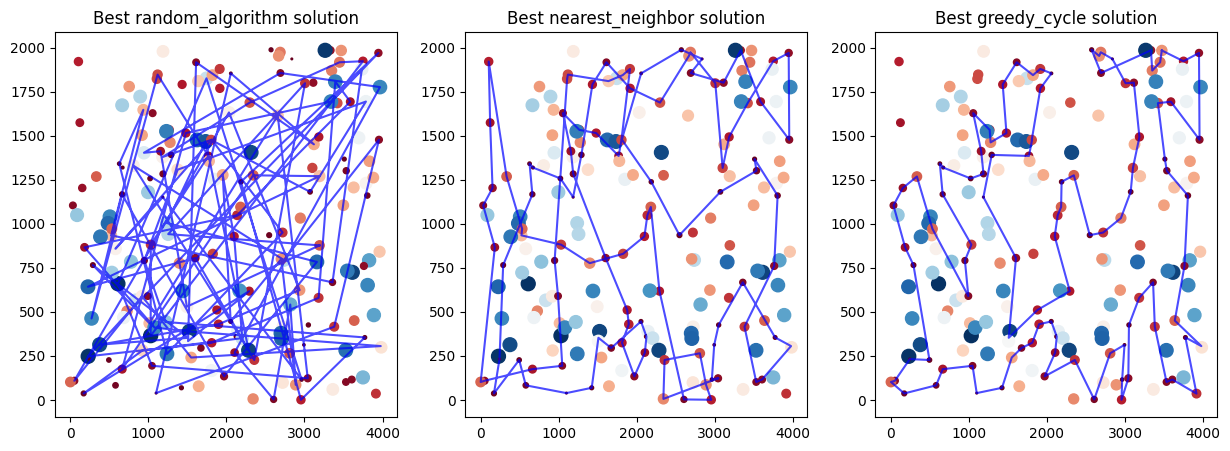

In [13]:
get_solution('TSPA.csv')

Instance: TSPB.csv

random_algorithm results:

Max score: 291613
Average score: 267607.175
Min/Best score: 233079
Selected Nodes: [42, 68, 37, 156, 83, 32, 89, 181, 138, 169, 61, 2, 153, 48, 144, 36, 145, 79, 18, 113, 176, 92, 73, 168, 118, 132, 34, 97, 117, 191, 155, 110, 91, 174, 81, 16, 53, 121, 96, 159, 189, 157, 190, 134, 100, 51, 178, 99, 142, 171, 115, 44, 80, 17, 182, 22, 119, 71, 106, 198, 130, 111, 31, 136, 135, 8, 21, 52, 124, 193, 122, 126, 7, 109, 164, 186, 165, 143, 154, 166, 140, 93, 90, 41, 102, 185, 29, 76, 75, 49, 87, 9, 82, 74, 12, 5, 67, 173, 195, 152, 42]

nearest_neighbor results:

Max score: 82631
Average score: 79282.58
Min/Best score: 77448
Selected Nodes: [63, 82, 115, 8, 16, 18, 12, 132, 185, 73, 136, 145, 80, 88, 153, 137, 99, 66, 143, 179, 101, 31, 34, 183, 197, 127, 121, 24, 103, 38, 131, 50, 154, 25, 36, 134, 165, 37, 157, 190, 135, 198, 19, 33, 29, 52, 44, 117, 196, 142, 148, 141, 130, 140, 174, 91, 51, 70, 67, 114, 162, 150, 71, 119, 59, 64, 129, 89, 15

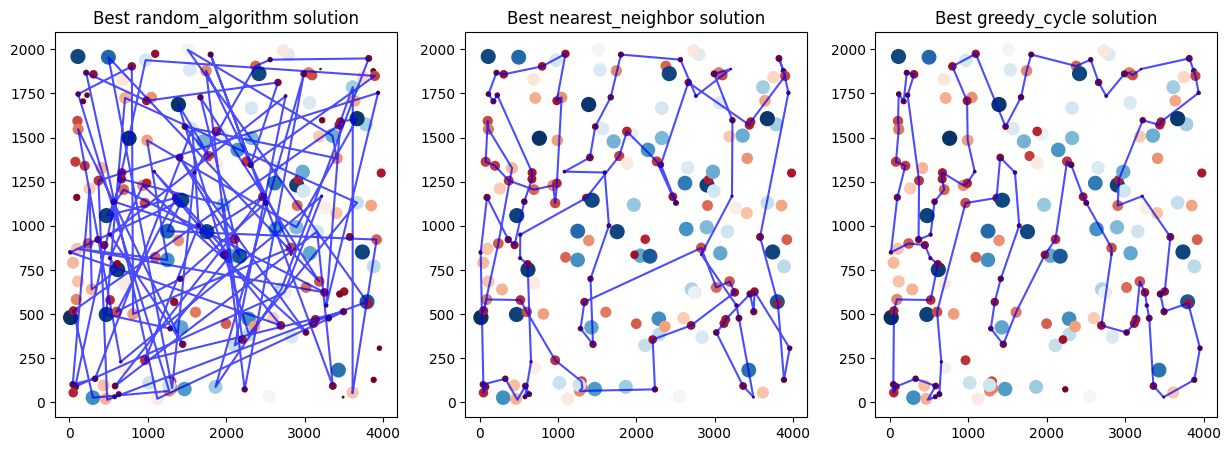

In [14]:
get_solution('TSPB.csv')

Instance: TSPC.csv

random_algorithm results:

Max score: 235599
Average score: 214484.575
Min/Best score: 190260
Selected Nodes: [163, 141, 183, 88, 61, 80, 95, 94, 179, 160, 175, 91, 73, 146, 138, 134, 40, 57, 181, 34, 192, 83, 29, 190, 72, 117, 155, 105, 87, 185, 126, 28, 31, 123, 119, 42, 17, 102, 108, 153, 187, 21, 170, 45, 129, 0, 62, 69, 178, 68, 81, 122, 156, 128, 115, 157, 100, 66, 186, 20, 10, 147, 180, 11, 193, 169, 127, 118, 96, 168, 30, 27, 16, 5, 131, 158, 135, 189, 18, 90, 148, 199, 151, 177, 4, 113, 77, 1, 112, 104, 75, 106, 125, 191, 67, 165, 145, 101, 172, 154, 163]

nearest_neighbor results:

Max score: 63697
Average score: 58872.68
Min/Best score: 56304
Selected Nodes: [190, 98, 6, 66, 156, 172, 141, 87, 79, 21, 194, 186, 88, 153, 114, 4, 77, 43, 149, 0, 19, 178, 164, 128, 132, 55, 195, 22, 117, 53, 62, 74, 163, 113, 185, 64, 20, 71, 61, 183, 103, 7, 32, 180, 81, 154, 144, 102, 133, 171, 108, 15, 18, 155, 93, 146, 182, 138, 36, 76, 161, 91, 121, 50, 69, 35, 86, 192,

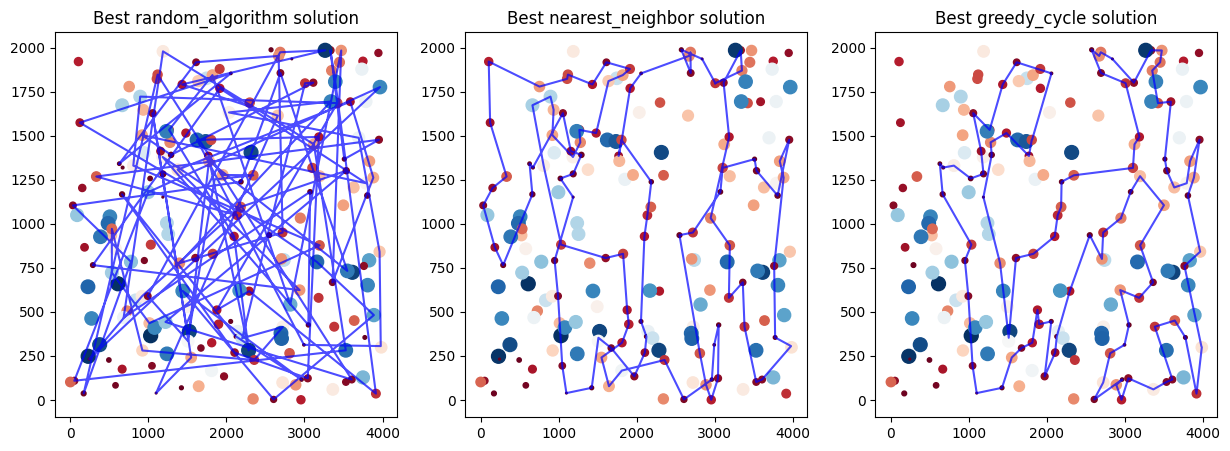

In [15]:
get_solution('TSPC.csv')

Instance: TSPD.csv

random_algorithm results:

Max score: 241464
Average score: 218998.345
Min/Best score: 195193
Selected Nodes: [159, 147, 32, 104, 22, 31, 176, 14, 153, 150, 181, 82, 149, 177, 199, 135, 59, 115, 163, 73, 81, 165, 156, 189, 175, 152, 6, 132, 105, 108, 109, 118, 164, 192, 187, 46, 110, 66, 188, 83, 140, 24, 162, 33, 52, 51, 85, 2, 170, 0, 146, 111, 50, 100, 3, 138, 56, 95, 179, 196, 126, 139, 19, 92, 93, 27, 157, 123, 68, 102, 41, 23, 94, 193, 72, 88, 191, 167, 185, 78, 70, 71, 28, 151, 26, 174, 137, 136, 117, 34, 15, 160, 61, 45, 142, 84, 79, 99, 134, 4, 159]

nearest_neighbor results:

Max score: 59846
Average score: 54290.68
Min/Best score: 50335
Selected Nodes: [12, 107, 139, 44, 117, 196, 150, 162, 67, 114, 85, 129, 64, 89, 159, 147, 58, 171, 72, 71, 119, 59, 193, 166, 28, 110, 158, 156, 91, 51, 70, 174, 140, 148, 141, 142, 130, 188, 161, 192, 21, 138, 82, 115, 8, 63, 16, 18, 132, 185, 73, 136, 61, 33, 29, 190, 135, 198, 66, 169, 99, 137, 88, 153, 80, 157, 145, 7

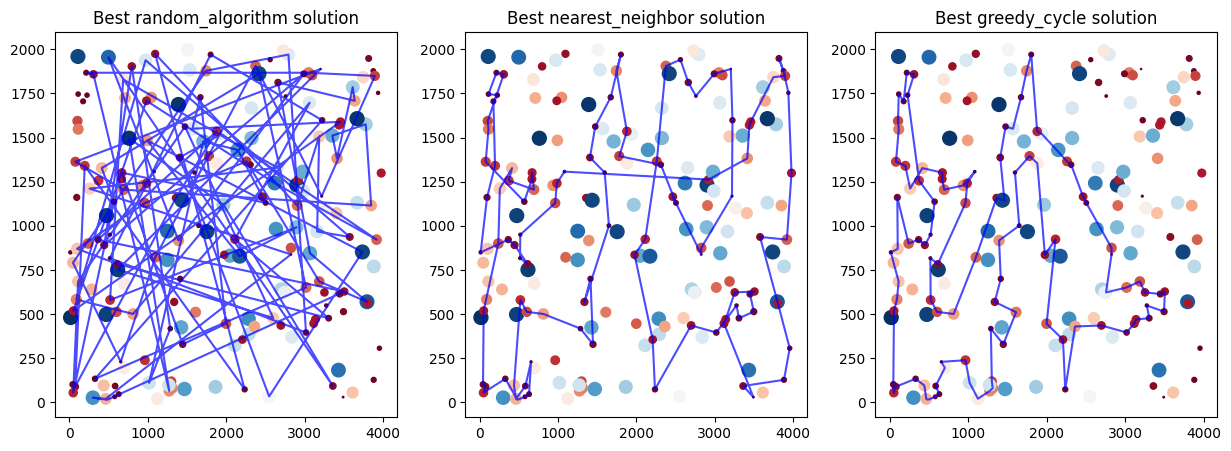

In [16]:
get_solution('TSPD.csv')